# Optimizers

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
#export
from exp.nb_08 import *

## Imagenette data

In [3]:
path = datasets.untar_data(datasets.URLs.IMAGENETTE_160)

In [4]:
tfms = [make_rgb, ResizeFixed(128), to_byte_tensor, to_float_tensor]

In [5]:
bs = 128

In [6]:
il = ImageList.from_files(path, tfms=tfms)

In [7]:
sd = SplitData.split_by_func(il, partial(grandparent_splitter, valid_name='val'))

In [8]:
ll = label_by_func(sd, parent_labeler, proc_y=CategoryProcessor())

In [9]:
data = ll.to_databunch(bs, c_in=3, c_out=10, num_workers=4)

In [10]:
nfs = [32, 64, 128, 256]

In [11]:
cbfs = [partial(AvgStatsCallback, accuracy),
        CudaCallback,
        partial(BatchTransformXCallback, norm_imagenette)]

In [12]:
learn, run = get_learn_run(nfs, data, 0.4, conv_layer, cbs=cbfs)

In [13]:
run.fit(1, learn)

train: [1.7610375647103305, tensor(0.3898, device='cuda:0')]
valid: [1.598233642578125, tensor(0.4420, device='cuda:0')]


## Refining the optimizer

In PyTorch `torch.optim` is simply is a dictionary that stores the hyper-parameters and references to the parameters of the model we want to train in parameter groups.

Our optimizer needs a `step` method and a `zero_grad` method. Ours will be more generic as the actual work is done by stepper functions. Want a different optimizer? Just write a new stepper function.

In [14]:
class Optimizer():
    def __init__(self, params, steppers, **defaults):

        self.param_groups = list(params)
        # ensure that this is a list of lists of tensors
        if not isinstance(self.param_groups[0], list):
            self.param_groups = [self.param_groups]
        
        # a dict containing e.g. lr or mom for every param group
        self.hypers = [{**defaults} for p in self.param_groups]
        # unpack so that every group has their own copy of the dict
        # otherwise would have ref to the same
        
        self.steppers = listify(steppers)
        
    def grad_params(self):
        return [(p, hyper) for pg, hyper in zip(self.param_groups, self.hypers) for p in pg if p.grad is not None]
        
    def zero_grad(self):
        for p, hyper in self.grad_params():
            p.grad.detach()
            p.grad.zero_()
            
    def step(self):
        for p, hyper in self.grad_params():
            compose(p, self.steppers, **hyper)

Let's use this to build vanilla SGD:

In [26]:
def sgd_step(p, lr, **kwargs):
    p.data.add_(-lr, p.grad.data)
    return p

Here we use, that our `compose` passes on any keyword arguments it got.

In [16]:
sgd_opt = partial(Optimizer, steppers=[sgd_step])

We have to adapt our callbacks because we have a separate list of dictionaries for our different parameter groups whereas PyTorch has all hyperparameters in the list of param groups:

In [17]:
#export
class Recorder(Callback):
    def begin_fit(self): self.lrs,self.losses = [],[]

    def after_batch(self):
        if not self.in_train: return
        self.lrs.append(self.opt.hypers[-1]['lr'])  # only lr of last layer is recorded
        self.losses.append(self.loss.detach().cpu())        

    def plot_lr  (self): plt.plot(self.lrs)
    def plot_loss(self): plt.plot(self.losses)
        
    def plot(self, skip_last=0):
        losses = [o.item() for o in self.losses]
        n = len(losses)-skip_last
        plt.xscale('log')
        plt.plot(self.lrs[:n], losses[:n])

In [18]:
#export
class ParamScheduler(Callback):
    _order=1
    def __init__(self, pname, sched_funcs):
        self.pname,self.sched_funcs = pname,listify(sched_funcs)

    def begin_batch(self): 
        if not self.in_train: return
        fs = self.sched_funcs
        if len(fs)==1: fs = fs*len(self.opt.param_groups)
        pos = self.n_epochs/self.epochs
        for f,h in zip(fs,self.opt.hypers): 
            h[self.pname] = f(pos)

In [19]:
#export
class LR_Find(Callback):
    _order=1
    def __init__(self, max_iter=100, min_lr=1e-6, max_lr=10):
        self.max_iter,self.min_lr,self.max_lr = max_iter,min_lr,max_lr
        self.best_loss = 1e9
        
    def begin_batch(self): 
        if not self.in_train: return
        pos = self.n_iter/self.max_iter
        lr = self.min_lr * (self.max_lr/self.min_lr) ** pos
        for h in self.opt.hypers: h['lr'] = lr
            
    def after_step(self):
        if self.n_iter>=self.max_iter or self.loss>self.best_loss*10:
            raise CancelTrainException()
        if self.loss < self.best_loss: self.best_loss = self.loss

Let's test this everything still works:

In [20]:
sched = combine_scheds([0.3, 0.7], [sched_cos(0.3, 0.6), sched_cos(0.6, 0.2)])

In [21]:
cbfs = [
    partial(AvgStatsCallback, accuracy),
    CudaCallback, Recorder,
    partial(ParamScheduler, 'lr', sched)
]

In [22]:
learn,run = get_learn_run(nfs, data, 0.4, conv_layer, cbs=cbfs, opt_func=sgd_opt)

In [23]:
%time run.fit(1, learn)

train: [1.741737314836358, tensor(0.3919, device='cuda:0')]
valid: [1.3328509521484375, tensor(0.5680, device='cuda:0')]
CPU times: user 2.66 s, sys: 1.04 s, total: 3.69 s
Wall time: 4.47 s


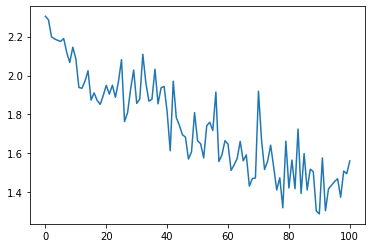

In [24]:
run.recorder.plot_loss()

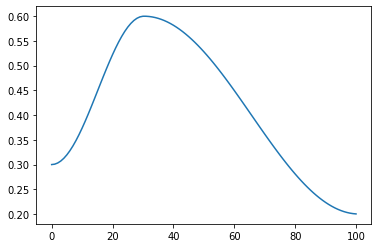

In [25]:
run.recorder.plot_lr()

## Weight decay

** Weight decay:**
`new_weight = weight - lr * weight.grad - lr * wd * weight`

**L2-regularization:**
`weight.grad += wd * weight`

We need to assign a default `wd` to the weight decay function to make sure that the `Optimizer` has a hyper-parameter of the same name even if not specified by the user.

In [28]:
#export
def weight_decay(p, lr, wd, **kwargs):
    p.data.mul_(1 - lr * wd)
    return p

weight_decay._defaults = dict(wd=0.)

In [29]:
weight_decay._defaults

{'wd': 0.0}

L2-regularization would be adding the `wd * weight` to the gradients:

In [30]:
#export
def l2_reg(p, lr, wd, **kwargs):
    p.grad.data.add_(wd, p.data)
    return p
l2_reg._defaults = dict(wd=0.)

We have to allow the steppers to maybe add their `_defaults` to the optimizers `defaults` in case it does not have certain hyper parameters:

In [32]:
#export
def maybe_update(origins, target, get_func):
    for o in origins:  # goes through steppers
        for k, v in get_func(o).items():
            if k not in target: target[k] = v
                
def get_defaults(s): return getattr(s, '_defaults', {})  # return empty dict if stepper does not have _defaults

In [33]:
#export
class Optimizer():
    def __init__(self, params, steppers, **defaults):
        self.steppers = listify(steppers)
        maybe_update(self.steppers, defaults, get_defaults)
        
        self.param_groups = list(params)  # might be a generator
        
        # ensure that this is a list of lists of tensors
        if not isinstance(self.param_groups[0], list):
            self.param_groups = [self.param_groups]
        
        # a dict containing e.g. lr or mom for every param group
        self.hypers = [{**defaults} for p in self.param_groups]
        # unpack so that every group has their own copy of the dict
        # otherwise would have ref to the same
        
        
    def grad_params(self):
        return [(p, hyper) for pg, hyper in zip(self.param_groups, self.hypers) for p in pg if p.grad is not None]
        
    def zero_grad(self):
        for p, hyper in self.grad_params():
            p.grad.detach()
            p.grad.zero_()
            
    def step(self):
        for p, hyper in self.grad_params():
            compose(p, self.steppers, **hyper)

In [34]:
#export
sgd_opt = partial(Optimizer, steppers=[weight_decay, sgd_step])

In [35]:
learn, run = get_learn_run(nfs, data, 0.4, conv_layer, cbs=cbfs, opt_func=sgd_opt)

Let's make sure this works as intended when we don't specify a `wd`:

In [36]:
model = learn.model

In [44]:
opt = sgd_opt(model.parameters(), lr=0.1)
test_eq(opt.hypers[0]['lr'], 0.1)
test_eq(opt.hypers[0]['wd'], 0.0)

In [48]:
opt = sgd_opt(model.parameters(), lr=0.1, wd=1e-4)
test_eq(opt.hypers[0]['lr'], 0.1)
test_eq(opt.hypers[0]['wd'], 1e-4)

In [49]:
cbfs = [partial(AvgStatsCallback,accuracy), CudaCallback]

In [50]:
learn, run = get_learn_run(nfs, data, 0.4, conv_layer, cbs=cbfs, opt_func=sgd_opt)

In [51]:
run.fit(1, learn)

train: [1.7815120526019854, tensor(0.3841, device='cuda:0')]
valid: [1.4918466796875, tensor(0.4680, device='cuda:0')]
